<a href="https://colab.research.google.com/github/naderghanbari/mcgill-capstone/blob/master/capstone_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import libraries

In [43]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pylab as plt
from IPython.display import HTML

### Load dataset
In this step we load the data from 2015 to the end of 2019.

In [2]:
# Download the preprocessed dataset
%%bash
mkdir -p data
curl https://storage.googleapis.com/capstone-data-lake/aggregated/indicents_crimes_date_division.csv --silent --output data/indicents_crimes_date_division.csv
echo Number of lines: `wc -l data/*`

Number of lines: 12265 data/indicents_crimes_date_division.csv


In [3]:
df = pd.read_csv("data/indicents_crimes_date_division.csv", parse_dates=["date"])

# Keep only dates in the [2015, 2019] range
df = df[df["date"].between("2015-01-01", "2019-12-31")]

# Convert type to Pandas date type
df["date"] = df["date"].dt.date
df.set_index("date", drop=True, inplace=True)
df.head()

,division,incidents,units_deployed,crimes
date,,,,
2015-01-01,1,34,59,3
2015-01-01,2,81,140,15
2015-01-01,3,70,118,5
2015-01-01,4,70,92,8
2015-01-01,5,84,137,15


### Split by division
In this step we divide the dataset into chunks, one chunk
per division.

In [53]:
# Split the data for each division
div_dfs = [y.drop(columns=["division"]) for _, y in df.groupby("division", as_index=False)]

# Function to display something for each division dataframe
def display_divs(what):
  for d, div in enumerate(div_dfs, start=1):
    display(HTML(f"<h2>Division {d}</h2>"))
    display(what(div))
    display(HTML("<hr />"))

# Print the head of all division dataframes
display_divs(lambda div: div.head())

,incidents,units_deployed,crimes
date,,,
2015-01-01,34,59,3
2015-01-02,33,42,6
2015-01-03,38,69,5
2015-01-04,128,176,4
2015-01-05,52,97,9


,incidents,units_deployed,crimes
date,,,
2015-01-01,81,140,15
2015-01-02,59,86,9
2015-01-03,63,128,14
2015-01-04,206,270,4
2015-01-05,99,168,20


,incidents,units_deployed,crimes
date,,,
2015-01-01,70,118,5
2015-01-02,61,104,15
2015-01-03,70,110,16
2015-01-04,130,180,8
2015-01-05,91,169,14


,incidents,units_deployed,crimes
date,,,
2015-01-01,70,92,8
2015-01-02,87,107,11
2015-01-03,81,127,17
2015-01-04,79,94,11
2015-01-05,101,133,14


,incidents,units_deployed,crimes
date,,,
2015-01-01,84,137,15
2015-01-02,69,200,12
2015-01-03,69,126,14
2015-01-04,106,168,10
2015-01-05,74,104,19


,incidents,units_deployed,crimes
date,,,
2015-01-01,73,107,11
2015-01-02,34,72,9
2015-01-03,59,123,10
2015-01-04,59,95,6
2015-01-05,39,71,12


### Statistics

In [54]:
# Print the descirption of all division dataframes
display_divs(lambda div: div.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
incidents,1826.0,28.392662,8.292180,10.0,24.0,28.0,32.0,185.0
units_deployed,1826.0,51.434283,19.697196,14.0,39.0,48.0,60.0,266.0
crimes,1826.0,5.124315,2.843573,0.0,3.0,5.0,7.0,19.0


,count,mean,std,min,25%,50%,75%,max
incidents,1826.0,56.756298,11.365715,30.0,50.00,56.0,62.0,206.0
units_deployed,1826.0,103.976999,26.907707,50.0,86.25,100.0,116.0,360.0
crimes,1826.0,10.957831,4.407450,1.0,8.00,11.0,14.0,38.0


,count,mean,std,min,25%,50%,75%,max
incidents,1826.0,66.596386,12.428856,33.0,59.0,65.0,73.0,198.0
units_deployed,1826.0,123.910186,30.175789,55.0,104.0,120.0,138.0,375.0
crimes,1826.0,12.784228,4.837354,1.0,9.0,12.0,16.0,43.0


,count,mean,std,min,25%,50%,75%,max
incidents,1826.0,66.627601,11.663707,32.0,59.00,66.0,73.0,195.0
units_deployed,1826.0,104.811062,24.323615,41.0,88.25,102.0,117.0,256.0
crimes,1826.0,14.150055,5.109587,2.0,11.00,14.0,17.0,58.0


,count,mean,std,min,25%,50%,75%,max
incidents,1826.0,64.008762,11.003906,36.0,57.0,63.0,70.0,142.0
units_deployed,1826.0,109.841731,26.101060,55.0,92.0,106.5,123.0,241.0
crimes,1826.0,16.307229,5.727542,3.0,12.0,16.0,20.0,48.0


,count,mean,std,min,25%,50%,75%,max
incidents,1826.0,45.500548,9.527595,18.0,39.0,45.0,51.0,93.0
units_deployed,1826.0,84.541073,23.922333,31.0,69.0,81.0,96.0,242.0
crimes,1826.0,11.776013,4.114085,2.0,9.0,11.0,14.0,33.0


### Visualizations

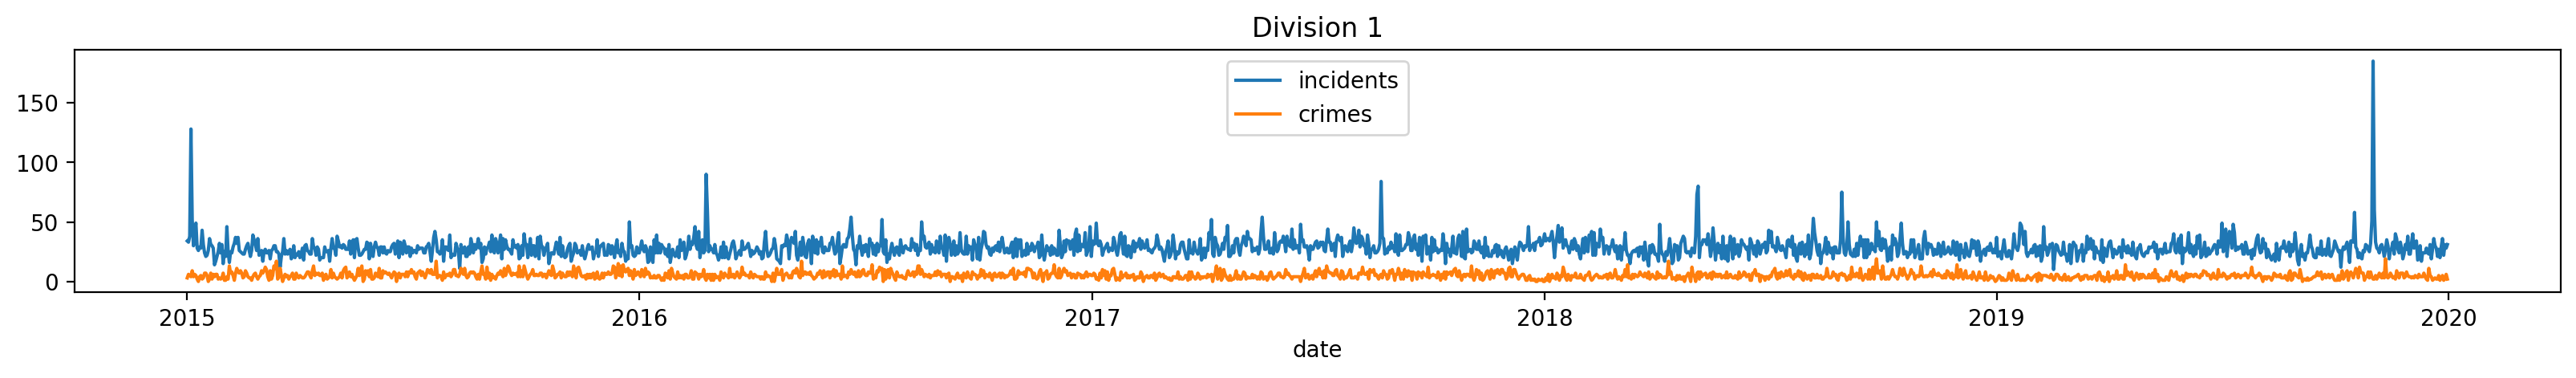

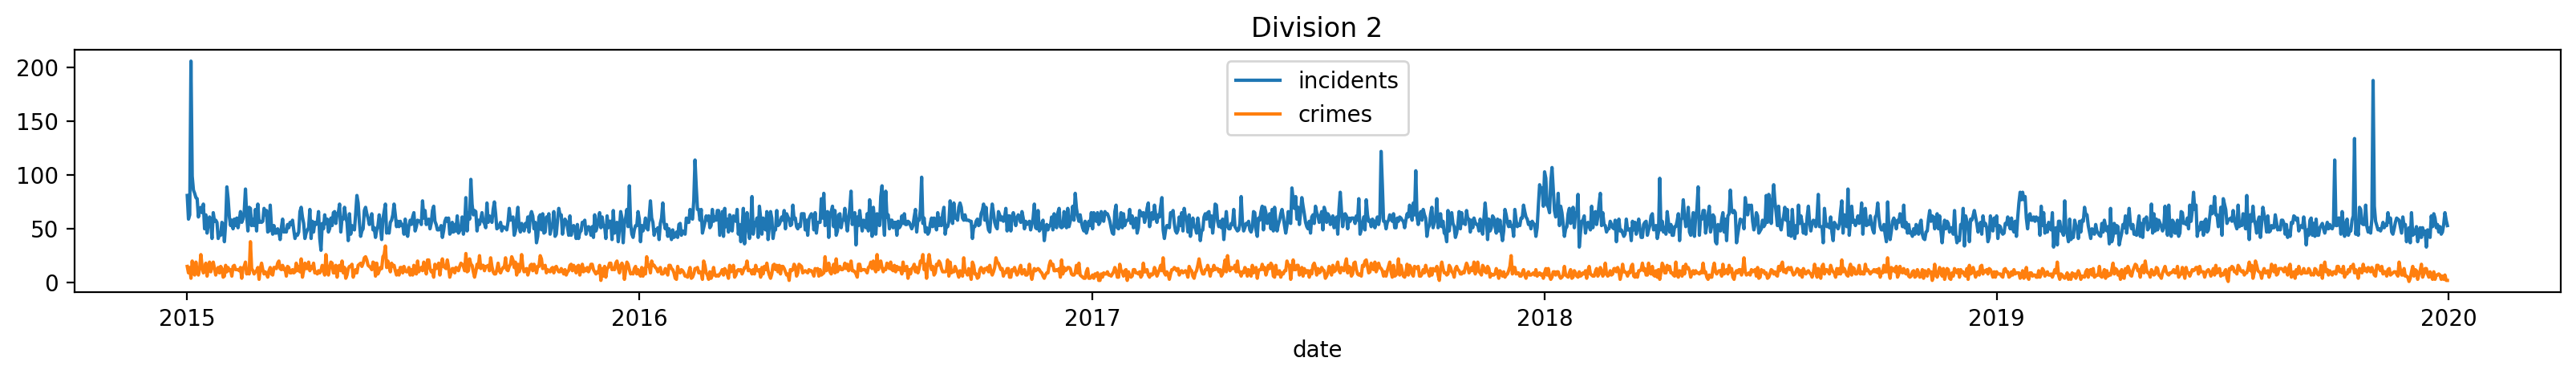

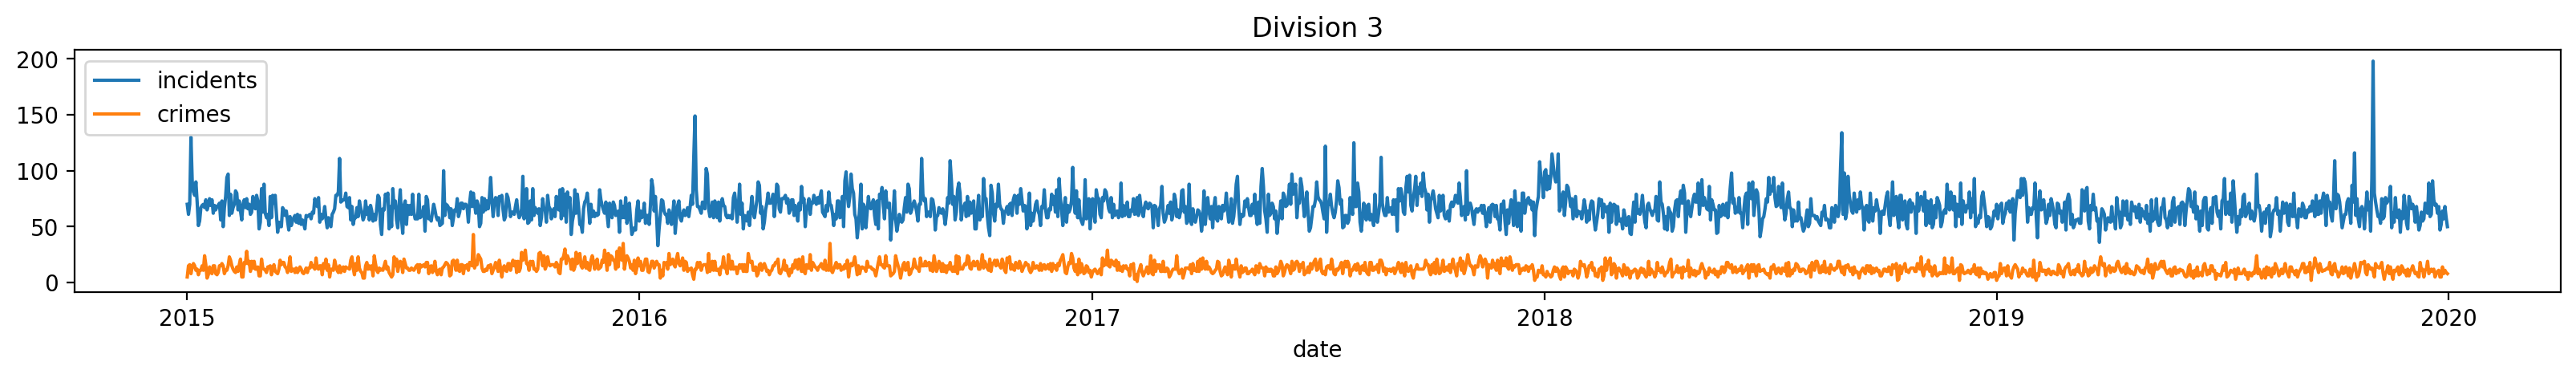

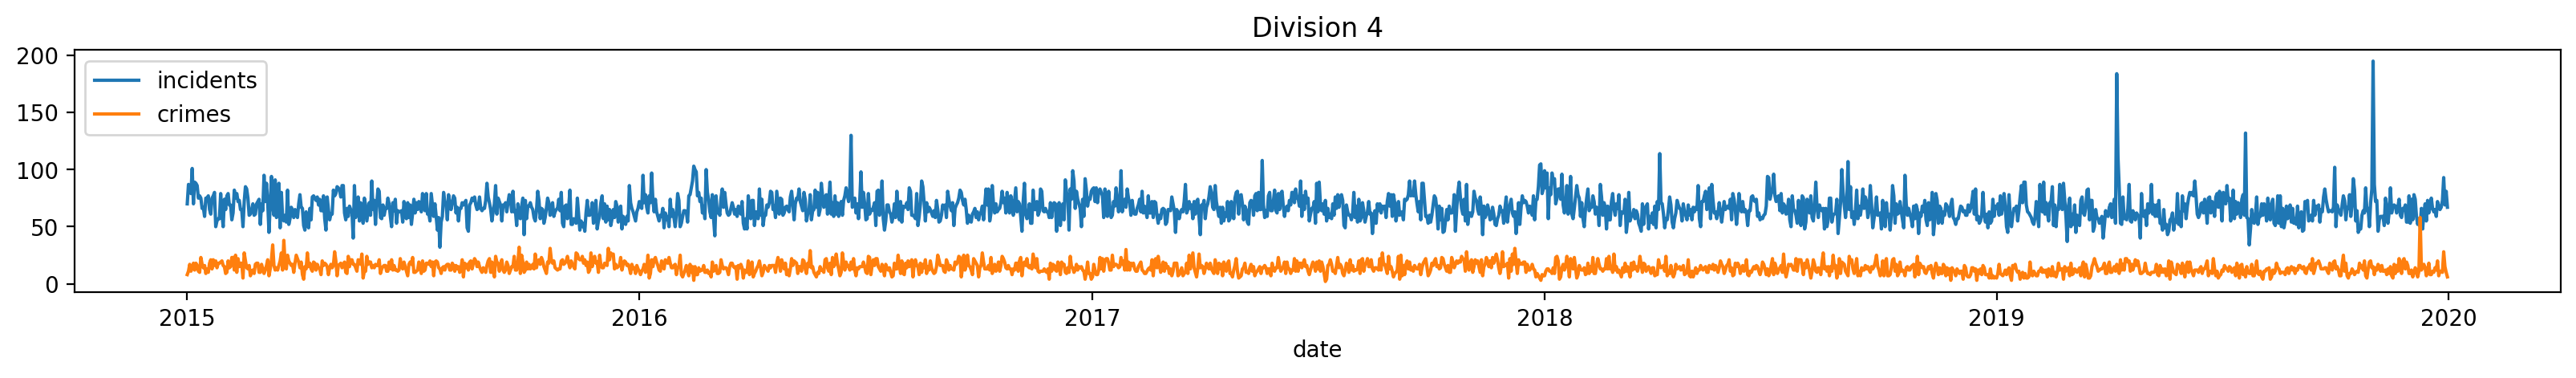

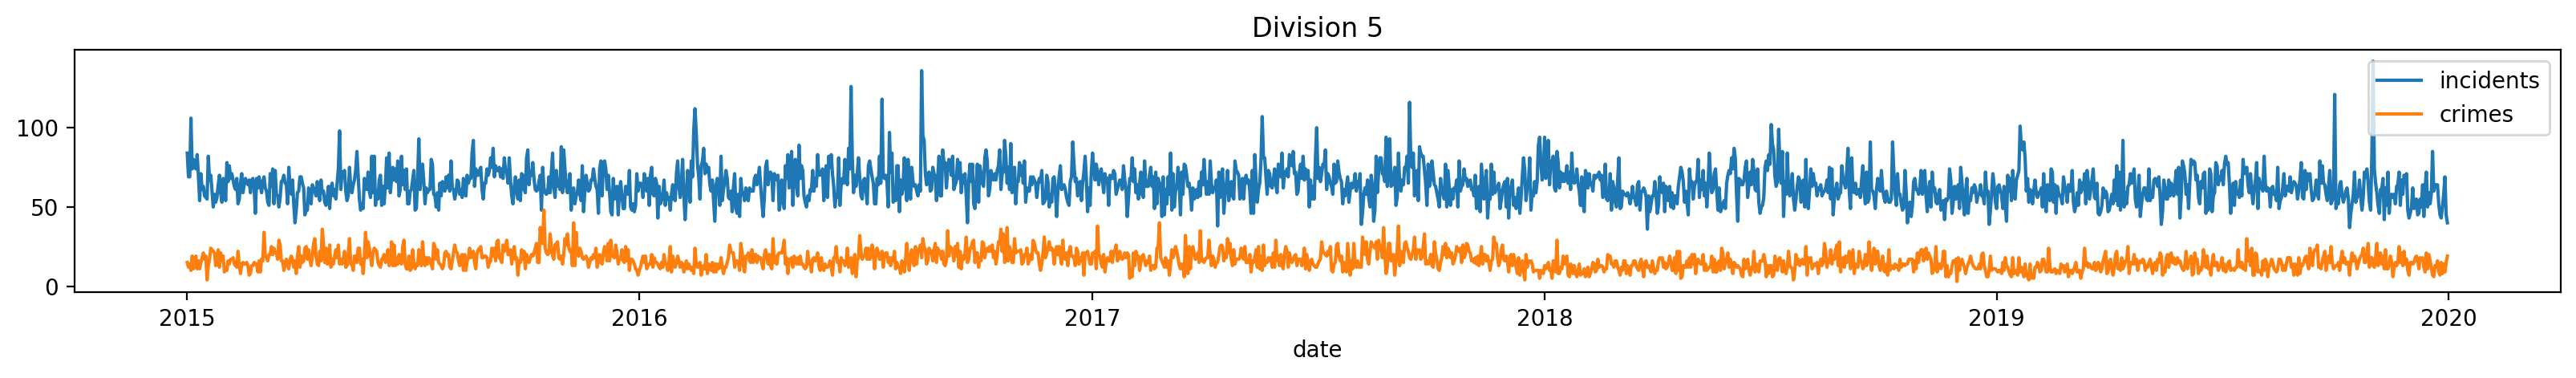

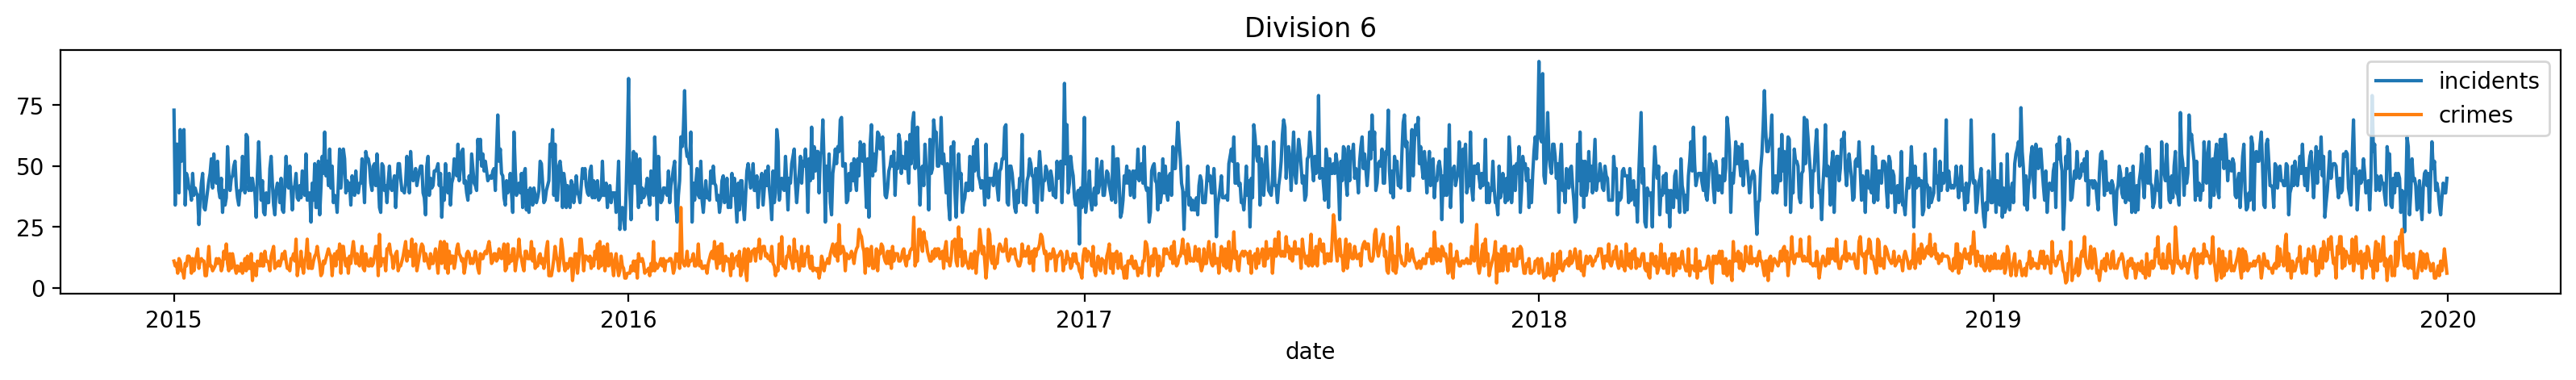

In [55]:
# Set plot size
plt.rcParams["figure.dpi"] = 200
plt.rcParams["figure.figsize"] = (20,2)

# Plot incidents and crimes for each division
for d, div in enumerate(div_dfs, start=1):
  div[["incidents", "crimes"]].plot(title=f"Division {d}");

# Windowing
In this step we prepare the data by adding engineered time-based features such as a window in the past.

In [7]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

# Test Training Split

- Random
- Squential (First 80% training, Last 20% test)